In [597]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import joblib
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import RFE

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
weight_decay = 1e-4
batch_size = 32
num_epochs = 75
num_runs = 2
max_patience = 13

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Using device: cuda


In [598]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, show_counts=True):
    
    total_rows = len(df)
    total_duplicates = df.duplicated().sum()
    
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "non_null_count": df.notna().sum(),
        "missing_count": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique_count": df.nunique(),
        "duplicates_in_dataset": total_duplicates
    })
    
    print(f"Dataset shape: {df.shape}")
    if show_counts:
        print(f"Total rows: {total_rows}")
        print(f"Total duplicate rows: {total_duplicates}")
    summary = summary.sort_values(by="missing_%", ascending=False)
    
    return summary

def outlier_handling(df, target_col, threshold_high=99, threshold_low=1):
    
    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=["number"]).columns.tolist()
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(0)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X, y)

    y_pred_proba = hgb.predict_proba(X)[:, 1]

    high_val = np.percentile(y_pred_proba, threshold_high)
    low_val = np.percentile(y_pred_proba, threshold_low)

    mask = (y_pred_proba < high_val) & (y_pred_proba > low_val)
    df_filtered = df_copy.loc[mask].reset_index(drop=True)

    print(f"Dropped: {len(df_copy) - len(df_filtered)} outlier rows")

    return df_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped cols: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    df_engi = df.copy()

    df_engi["TotalPastDue"] = (
        df_engi["NumberOfTime30-59DaysPastDueNotWorse"] +
        df_engi["NumberOfTimes90DaysLate"] +
        df_engi["NumberOfTime60-89DaysPastDueNotWorse"]
    )
    
    df_engi["HasDelinquencyBinary"] = (df_engi["TotalPastDue"] > 0).astype(int)
    
    df_engi["HasMultipleLate"] = (df_engi["TotalPastDue"] >= 2).astype(int)
    
    df_engi["MajorDelinquencyBinary"] = (
        (df_engi["NumberOfTimes90DaysLate"] > 0) |
        (df_engi["NumberOfTime60-89DaysPastDueNotWorse"] > 0)
    ).astype(int)
    
    df_engi["LatePaymentsPerAge"] = df_engi["TotalPastDue"] / (df_engi["age"] + 1)
    
    df_engi["LatePaymentsPerCreditLine"] = df_engi["TotalPastDue"] / (df_engi["NumberOfOpenCreditLinesAndLoans"] + 1)

    df_engi["NormalizedUtilization"] = np.sqrt(df_engi["RevolvingUtilizationOfUnsecuredLines"])
    
    df_engi["HighUtilizationFlag"] = (df_engi["RevolvingUtilizationOfUnsecuredLines"] > 0.5).astype(int)

    df_engi["DelinquencyInteraction"] = df_engi["TotalPastDue"] * df_engi["RevolvingUtilizationOfUnsecuredLines"]

    utilization_bins = [-0.01, 0.1, 0.3, 0.6, 0.9, 1.5, 10]
    utilization_labels = ["Very Low", "Low", "Moderate", "High", "Very High", "Extreme"]
    df_engi["UtilizationBucket"] = pd.cut(df_engi["RevolvingUtilizationOfUnsecuredLines"], bins=utilization_bins, labels=utilization_labels)

    late_bins = [-1, 0, 1, 3, 6, np.inf]
    late_labels = ["NoLate", "FewLate", "ModerateLate", "FrequentLate", "ChronicLate"]
    df_engi["LatePaymentBucket"] = pd.cut(df_engi["TotalPastDue"], bins=late_bins, labels=late_labels)

    return df_engi

def drop_high_missing_cols(df, threshold=0.3):

    missing_frac = df.isna().mean().sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        'MissingCount': df.isna().sum(),
        'MissingPercent': (missing_frac * 100).round(2)
    })

    if df.isna().sum().sum() > 0:
        print(missing_summary.to_string())
    
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped: {len(hm_cols_to_drop)} high missing cols")
        print(f"Dropped cols: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No high missing cols dropped")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    unique_counts = df[cat_cols].nunique().sort_values(ascending=False)
    unique_summary = pd.DataFrame({
        'UniqueCount': unique_counts,
        'UniquePercent': (unique_counts / len(df) * 100).round(2)
    })

    if cat_cols:
        print(unique_summary.to_string())

    hc_cols_to_drop = unique_counts[unique_counts > threshold].index.tolist()

    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped: {len(hc_cols_to_drop)} high cardinality cols")
        print(f"Dropped cols: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high cardinality cols dropped")

    return df_high, hc_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):

    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    if not cat_cols:
        print("No rare categories cols collapsed")
        
    rare_maps = {}

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True).sort_values(ascending=False)
        freq_summary = pd.DataFrame({
            'Count': df_copy[col].value_counts(),
            'Percent': (freqs * 100).round(2)
        })
        print(f"Column: {col}")
        print(freq_summary.to_string())

        rare_cats = freqs[freqs < threshold].index

        if len(rare_cats) > 0:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Collapsed: {len(rare_cats)} rare categories")
            print(f"Categories collapsed: {list(rare_cats)}")
        else:
            print("No rare categories cols collapsed")

    return df_copy, rare_maps

def drop_low_correlated_to_target(df, y, threshold=0.34, bias_mode=None):

    df_temp = df.copy()

    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    df_temp['target'] = y
    corr_with_target = df_temp.corr()['target'].drop('target')
        
    if bias_mode is None:
        dropped_cols = corr_with_target[abs(corr_with_target) < threshold].index.tolist()
    elif bias_mode is True:
        dropped_cols = corr_with_target[(corr_with_target > 0) & (corr_with_target < threshold)].index.tolist()
    else: 
        dropped_cols = corr_with_target[(corr_with_target < 0) & (corr_with_target > -threshold)].index.tolist()

    plt.figure(figsize=(10, 6))
    corr_with_target.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'+{threshold}')
    plt.axhline(y=-threshold, color='red', linestyle='--', label=f'-{threshold}')
    plt.title("Feature Correlation with Target")
    plt.ylabel("Correlation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if dropped_cols:
        df_corr = df.drop(columns=dropped_cols)
        print(f"Dropped: {len(dropped_cols)} low correlated to target cols")
        print(f"Dropped cols: {dropped_cols}")
    else:
        df_corr = df.copy()
        print("No low correlated to target cols dropped")

    return df_corr, dropped_cols

def log_transform_skewed(df, skew_threshold=1.0):
    
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

    for col in numeric_cols:
        if df_copy[col].isna().all():
            continue 
        skew = df_copy[col].skew()
        if abs(skew) > skew_threshold:
            if (df_copy[col] >= 0).all():
                df_copy[col] = np.log1p(df_copy[col])
                print(f"Log-transformed: {col}")
            else:
                print(f"Skipped log transform (negative values): {col}")
    
    return df_copy

def plot_feature_importance(df, target, random_state=42, bias_mode=None):

    df_temp = df.copy()
    
    feature_cols = df_temp.columns.tolist()
    
    cat_cols = df_temp[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes
    
    X_train, X_val, y_train, y_val = train_test_split(
        df_temp[feature_cols], target, test_size=0.2, random_state=random_state, stratify=target
    )
    
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    
    if bias_mode is True:
        scale_pos_weight = pos_count / neg_count
    elif bias_mode is False:
        scale_pos_weight = neg_count / pos_count
    else:
        scale_pos_weight = 1
    
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["auc"],
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.03,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.7,
        gamma=0.5,
        reg_alpha=0.05,
        reg_lambda=0.8,
        n_estimators=1500,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        early_stopping_rounds=100,
        callbacks=[xgb.callback.LearningRateScheduler(lambda epoch: 0.03 * (0.99 ** epoch))]
    )
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    importance_dict = model.get_booster().get_score(importance_type='gain')
    all_importances = pd.Series({col: importance_dict.get(col, 0.0) for col in feature_cols})
    all_importances = all_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(all_importances.index[::-1], all_importances.values[::-1], color='skyblue')
    plt.xlabel("Feature Importance (gain)")
    plt.title("XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()

def select_features(df, target, n_features_to_select=20, random_state=42, bias_mode=None):

    df_temp = df.copy()

    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    X_train_full, _, y_train, _ = train_test_split(
        df_temp, target, test_size=0.2, random_state=random_state, stratify=target
    )

    X_train = X_train_full.drop(columns=cat_cols).astype(np.float32)

    neg_count = sum(y_train == 0)
    pos_count = sum(y_train == 1)

    if bias_mode is True:
        scale_pos_weight = pos_count / neg_count
    elif bias_mode is False:
        scale_pos_weight = neg_count / pos_count
    else:
        scale_pos_weight = 1

    base_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["auc"],
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.03,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.7,
        gamma=0.5,
        reg_alpha=0.05,
        reg_lambda=0.8,
        n_estimators=1500,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        callbacks=[xgb.callback.LearningRateScheduler(lambda epoch: 0.03 * (0.99 ** epoch))]
    )

    selector = RFE(estimator=base_model, n_features_to_select=n_features_to_select, step=1)
    selector.fit(X_train, y_train)

    selected_num_features = X_train.columns[selector.support_].tolist()
    rfe_num_cols_to_drop = [col for col in X_train.columns if col not in selected_num_features]

    df_selected = df[
        selected_num_features + [col for col in cat_cols if col in df.columns]
    ].copy()

    print(f"Dropped: {len(rfe_num_cols_to_drop)} numerical features via RFE")
    print(f"Dropped cols: {rfe_num_cols_to_drop}")

    return df_selected, rfe_num_cols_to_drop
    
def impute_and_scale(df, threshold=1.0, num_col_order=None, cat_col_order=None):
    
    df_copy = df.copy()
    
    num_imputer = None
    cat_imputer = None
    robust_scaler = None
    std_scaler = None
    skewed_cols = []
    normal_cols = []
    
    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        
        num_imputer = SimpleImputer(strategy='median')
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.fit_transform(df_copy[num_col_order])
        
        skewness = pd.DataFrame(df_copy[num_col_order]).skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > threshold].index.tolist()
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols])
        
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols])

    if cat_col_order:
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_col_order] = cat_imputer.fit_transform(df_copy[cat_col_order])
    
    df_processed = df_copy.copy()
    
    print("Imputed, flagged, and scaled features")
    
    return (
        df_processed,
        num_imputer,
        cat_imputer,
        robust_scaler,
        std_scaler,
        skewed_cols,
        normal_cols
    )

def transform_val_test(
    df, 
    cols_to_drop, 
    rare_maps, 
    num_imputer, 
    cat_imputer, 
    robust_scaler, 
    std_scaler,
    num_col_order=None, 
    cat_col_order=None,
    train_columns=None
):
    
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if rare_maps:
        for col, rare_cats in rare_maps.items():
            if col in df_copy.columns and isinstance(df_copy[col].dtype, pd.CategoricalDtype):
                df_copy[col] = df_copy[col].cat.add_categories('Other')     
                df_copy[col] = df_copy[col].where(~df_copy[col].isin(rare_cats), 'Other')
    
    if num_col_order:
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        df_copy[num_col_order] = num_imputer.transform(df_copy[num_col_order])

        if robust_scaler:
            skewed_cols = robust_scaler.feature_names_in_
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols])

        if std_scaler:
            normal_cols = [c for c in num_col_order if c not in robust_scaler.feature_names_in_]
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols])

    if cat_col_order:
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[cat_col_order] = cat_imputer.transform(df_copy[cat_col_order])

    if train_columns is not None:
        df_copy = df_copy.reindex(columns=train_columns, fill_value=0)

    print("Imputed, flagged, and scaled features")
                
    return df_copy
    
def check_and_drop_duplicates(df, target=None, drop_target_na=False, show_info=True):
    
    df_cleaned = df.copy()
    target_cleaned = None
    
    total_duplicates = df_cleaned.duplicated().sum()
    if total_duplicates > 0:
        df_cleaned = df_cleaned.drop_duplicates(keep='first')
        if show_info:
            print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
    
    if target is not None:
        target_cleaned = pd.Series(target).reindex(df_cleaned.index)
        if drop_target_na:
            mask = target_cleaned.notna()
            dropped = len(target_cleaned) - mask.sum()
            if dropped > 0 and show_info:
                print(f"Dropped {dropped} rows with missing target values")
            df_cleaned = df_cleaned.loc[mask].reset_index(drop=True)
            target_cleaned = target_cleaned.loc[mask].reset_index(drop=True)
        else:
            target_cleaned = target_cleaned.reset_index(drop=True)
        return df_cleaned, target_cleaned
    else:
        return df_cleaned

def fast_fbeta_scores(y_true, y_probs, thresholds, beta=2):
    
    y_true = np.asarray(y_true)
    y_probs = np.asarray(y_probs)
    thresholds = np.asarray(thresholds)

    preds = y_probs[:, None] > thresholds[None, :] 

    TP = (preds & (y_true[:, None] == 1)).sum(axis=0)
    FP = (preds & (y_true[:, None] == 0)).sum(axis=0)
    FN = ((~preds) & (y_true[:, None] == 1)).sum(axis=0)

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    beta_sq = beta ** 2
    f_beta = (1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall + 1e-8)

    return f_beta

In [599]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [600]:
#summary
print(dataset_summary(df_train))
df_train.head(5)

Dataset shape: (150000, 11)
Total rows: 150000
Total duplicate rows: 609
                                        dtype  non_null_count  missing_count  \
MonthlyIncome                         float64          120269          29731   
NumberOfDependents                    float64          146076           3924   
SeriousDlqin2yrs                        int64          150000              0   
age                                     int64          150000              0   
RevolvingUtilizationOfUnsecuredLines  float64          150000              0   
DebtRatio                             float64          150000              0   
NumberOfTime30-59DaysPastDueNotWorse    int64          150000              0   
NumberOfOpenCreditLinesAndLoans         int64          150000              0   
NumberOfTimes90DaysLate                 int64          150000              0   
NumberRealEstateLoansOrLines            int64          150000              0   
NumberOfTime60-89DaysPastDueNotWorse    int64  

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


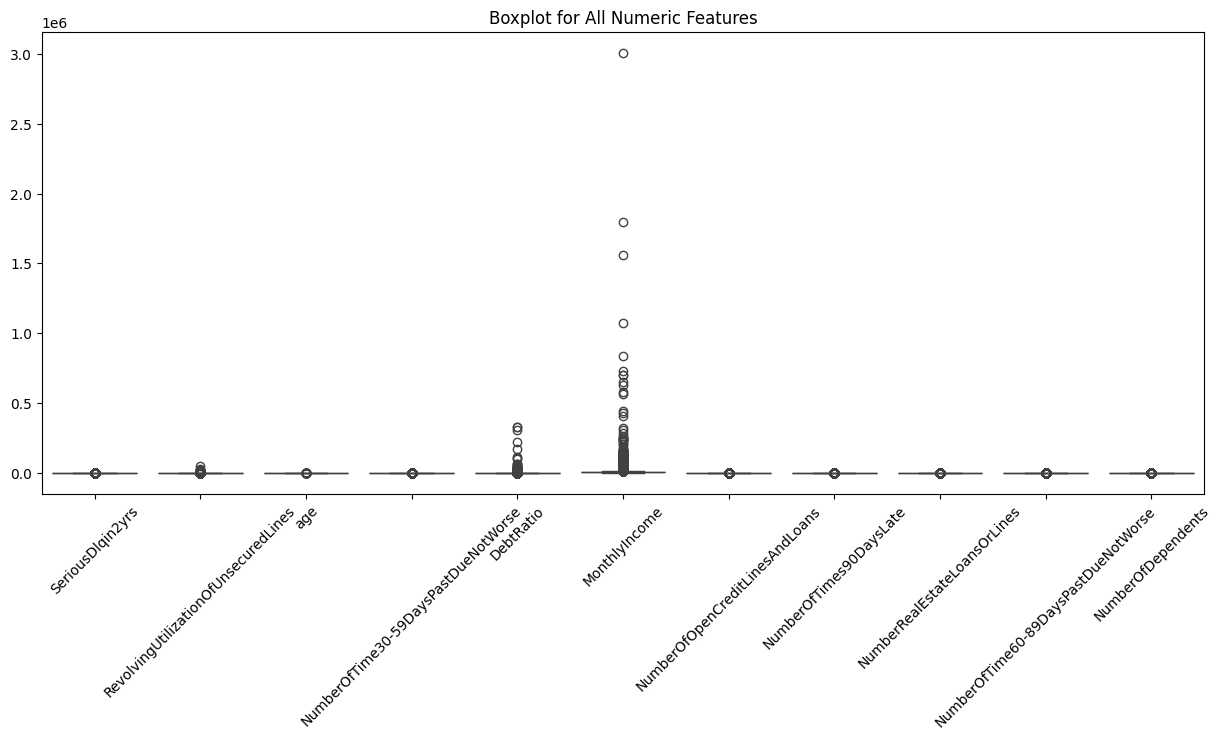

Dropped: 105 outlier rows


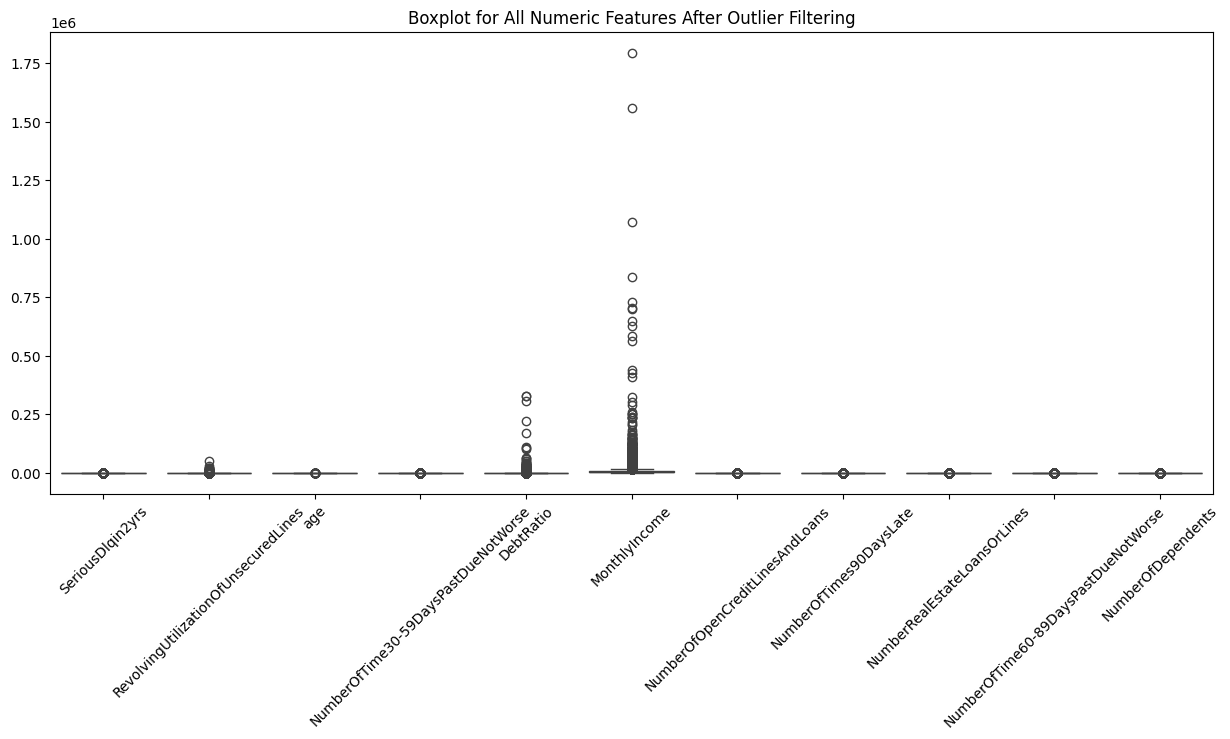

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149893.000000,149893.000000,149893.000000,149893.000000,149893.000000,1.498930e+05,149893.000000,149893.000000,149893.000000,149893.000000,149893.000000
mean,0.066587,6.052417,52.285537,0.420387,353.106555,5.330598e+03,8.454151,0.265016,1.018493,0.239771,0.737546
std,0.249307,249.844453,14.758172,4.193831,2038.434023,1.062576e+04,5.146043,4.170099,1.129532,4.156362,1.106976
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029931,41.000000,0.000000,0.175295,1.560000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154247,52.000000,0.000000,0.366579,4.361000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.558758,63.000000,0.000000,0.868479,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [601]:
# Outlier Handling
numeric_df = df_train.select_dtypes(include=['number'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

df_train = df_train[df_train['age'] > 0].reset_index(drop=True) 

df_train = df_train.sort_values(by="MonthlyIncome", ascending=False).iloc[1:].reset_index(drop=True) 

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

df_filtered = outlier_handling(
    df_train,
    target_col="SeriousDlqin2yrs",
    threshold_high=99.97,
    threshold_low=0.03
)

numeric_df = df_filtered.select_dtypes(include=['number'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features After Outlier Filtering")
plt.xticks(rotation=45)
plt.show()

df_filtered.describe()

In [602]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_filtered)
print(target.value_counts())

Dropped cols: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139912
1      9981
Name: count, dtype: int64


In [603]:
original_cols = df_features.select_dtypes(include=['number']).columns.tolist()
print(original_cols)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [604]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [605]:
# Engineer_features
df_engi = engineer_features(X_train)

In [606]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_engi, threshold=0.17)

                                      MissingCount  MissingPercent
DebtRatio                                        0            0.00
DelinquencyInteraction                           0            0.00
HasDelinquencyBinary                             0            0.00
HasMultipleLate                                  0            0.00
HighUtilizationFlag                              0            0.00
LatePaymentBucket                                0            0.00
LatePaymentsPerAge                               0            0.00
LatePaymentsPerCreditLine                        0            0.00
MajorDelinquencyBinary                           0            0.00
MonthlyIncome                                    0            0.00
NormalizedUtilization                            0            0.00
NumberOfDependents                               0            0.00
NumberOfOpenCreditLinesAndLoans                  0            0.00
NumberOfTime30-59DaysPastDueNotWorse             0            

In [607]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

                   UniqueCount  UniquePercent
UtilizationBucket            6           0.01
LatePaymentBucket            5           0.01
No high cardinality cols dropped


In [608]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_high, threshold=0.067)

Column: UtilizationBucket
                   Count  Percent
UtilizationBucket                
Very Low           41116    42.93
Low                18248    19.05
Moderate           14077    14.70
Very High          12381    12.93
High                9737    10.17
Extreme              226     0.24
Collapsed: 1 rare categories
Categories collapsed: ['Extreme']
Column: LatePaymentBucket
                   Count  Percent
LatePaymentBucket                
NoLate             76536    79.78
FewLate            11059    11.53
ModerateLate        5613     5.85
FrequentLate        1995     2.08
ChronicLate          728     0.76
Collapsed: 3 rare categories
Categories collapsed: ['ModerateLate', 'FrequentLate', 'ChronicLate']


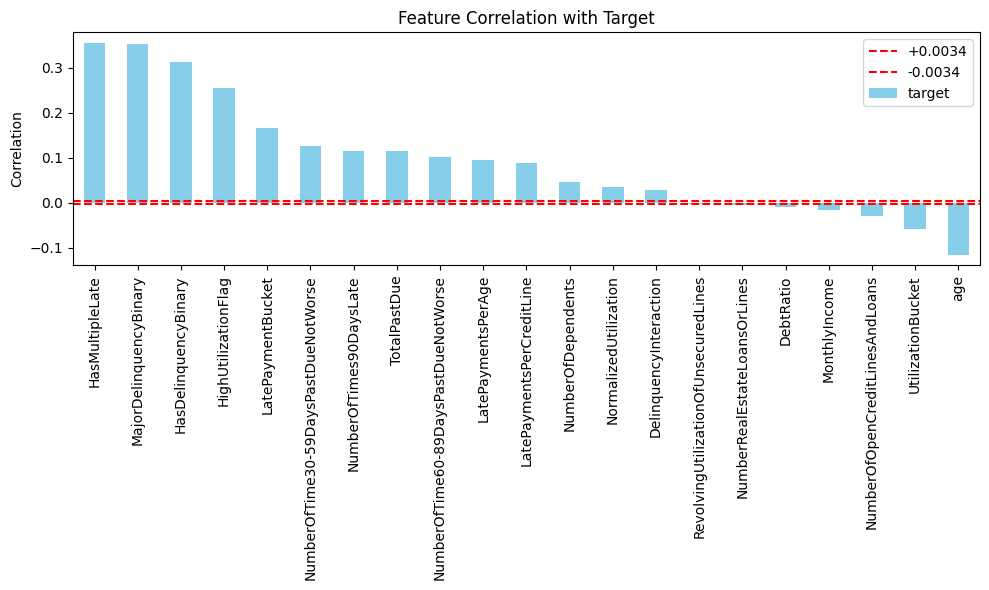

Dropped: 1 low correlated to target cols
Dropped cols: ['RevolvingUtilizationOfUnsecuredLines']


In [609]:
# Drop low correlated features to target
df_corr, low_corr_cols_to_drop = drop_low_correlated_to_target(df_collapsed, y_train, threshold=0.0034, bias_mode=False)

In [610]:
#log transform skewed
df_log = log_transform_skewed(df_corr)
df_log.describe()

Log-transformed: NumberOfTime30-59DaysPastDueNotWorse
Log-transformed: DebtRatio
Log-transformed: MonthlyIncome
Log-transformed: NumberOfOpenCreditLinesAndLoans
Log-transformed: NumberOfTimes90DaysLate
Log-transformed: NumberRealEstateLoansOrLines
Log-transformed: NumberOfTime60-89DaysPastDueNotWorse
Log-transformed: NumberOfDependents
Log-transformed: TotalPastDue
Log-transformed: HasDelinquencyBinary
Log-transformed: HasMultipleLate
Log-transformed: MajorDelinquencyBinary
Log-transformed: LatePaymentsPerAge
Log-transformed: LatePaymentsPerCreditLine
Log-transformed: NormalizedUtilization
Log-transformed: HighUtilizationFlag
Log-transformed: DelinquencyInteraction


,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TotalPastDue,HasDelinquencyBinary,HasMultipleLate,MajorDelinquencyBinary,LatePaymentsPerAge,LatePaymentsPerCreditLine,NormalizedUtilization,HighUtilizationFlag,DelinquencyInteraction
count,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000,95931.000000
mean,52.286602,0.147449,1.522146,6.754283,2.089070,0.056902,0.574244,0.047947,0.396499,0.208992,0.140138,0.060232,0.060557,0.012644,0.059296,0.357655,0.190760,0.139010
std,14.770558,0.393300,2.625004,3.551791,0.597900,0.293894,0.500921,0.267932,0.528832,0.497492,0.278385,0.195248,0.195724,0.102261,0.281760,0.262951,0.309574,0.441777
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,0.161752,7.369286,1.791759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159735,0.000000,0.000000
50%,52.000000,0.000000,0.312459,8.388450,2.197225,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332403,0.000000,0.000000
75%,63.000000,0.000000,0.624238,8.909370,2.484907,0.000000,1.098612,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.558171,0.693147,0.000000
max,109.000000,4.595120,12.696011,14.260261,4.077537,4.595120,4.007333,4.595120,3.044522,5.686975,0.693147,0.693147,0.693147,2.664700,5.686975,5.421350,0.693147,9.583076


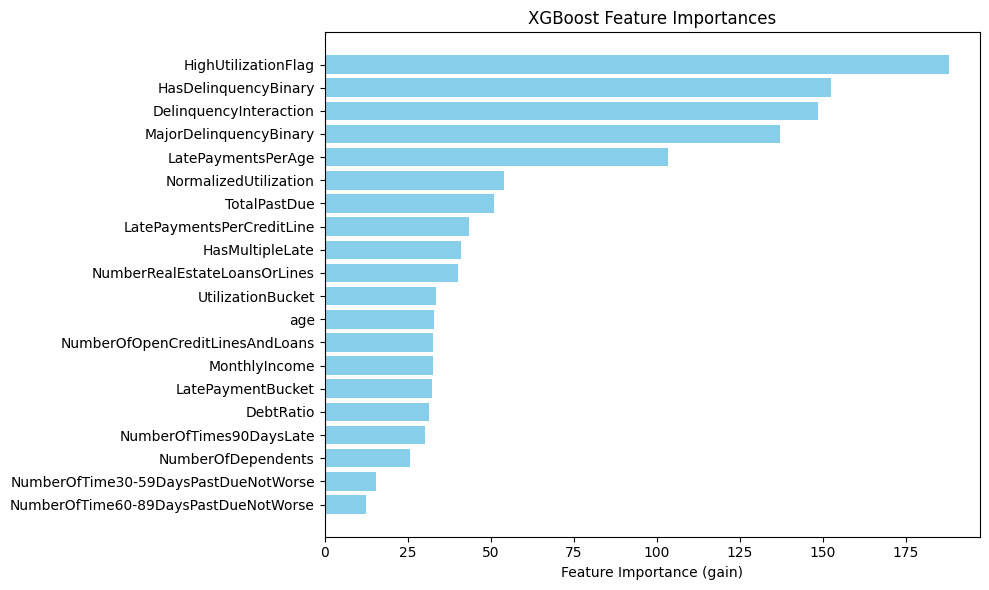

In [612]:
# Plot features
plot_feature_importance(df_log, y_train, bias_mode=False)

In [613]:
# RFE numeric Feature selection
df_selected, rfe_cols_to_drop = select_features(df_corr, y_train, n_features_to_select=16, bias_mode=False) 

Dropped: 2 numerical features via RFE
Dropped cols: ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']


In [614]:
# Columns
num_col_order = df_selected.select_dtypes(include=['number']).columns.tolist()
cat_col_order =  df_selected.select_dtypes(include=['object', 'category']).columns.tolist()
print(num_col_order)
print(cat_col_order)

['age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfDependents', 'TotalPastDue', 'HasDelinquencyBinary', 'HasMultipleLate', 'MajorDelinquencyBinary', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'NormalizedUtilization', 'HighUtilizationFlag', 'DelinquencyInteraction']
['UtilizationBucket', 'LatePaymentBucket']


In [615]:
# Impute and scale
df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler, skewed_col_order, normal_cols = impute_and_scale(
    df_selected,
    threshold=1.0,
    num_col_order=num_col_order,
    cat_col_order=cat_col_order
)

Imputed, flagged, and scaled features


In [616]:
# Skewed columns
print(skewed_col_order)

['DelinquencyInteraction', 'DebtRatio', 'MonthlyIncome', 'NormalizedUtilization', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'TotalPastDue', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'HasMultipleLate', 'MajorDelinquencyBinary', 'NumberOfDependents', 'HasDelinquencyBinary', 'NumberOfOpenCreditLinesAndLoans', 'HighUtilizationFlag']


In [617]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + hc_cols_to_drop + low_corr_cols_to_drop + rfe_cols_to_drop

X_val = engineer_features(X_val)
X_val = transform_val_test(
    X_val, 
    all_cols_to_drop, 
    rare_maps, 
    num_imputer, 
    cat_imputer, 
    robust_scaler, 
    std_scaler,
    num_col_order=num_col_order,
    cat_col_order=cat_col_order,
    train_columns=df_processed.columns
)

X_test = engineer_features(X_test)
X_test = transform_val_test(
    X_test, 
    all_cols_to_drop, 
    rare_maps, 
    num_imputer, 
    cat_imputer, 
    robust_scaler, 
    std_scaler,
    num_col_order=num_col_order,
    cat_col_order=cat_col_order,
    train_columns=df_processed.columns
)

X_train = df_processed.copy()

Imputed, flagged, and scaled features
Imputed, flagged, and scaled features


In [618]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped 418 duplicate rows. Remaining: 95513


In [619]:
#summary
print(dataset_summary(X_train))

Dataset shape: (95513, 36)
Total rows: 95513
Total duplicate rows: 0
                                             dtype  non_null_count  \
age                                        float64           95513   
DebtRatio                                  float64           95513   
MonthlyIncome                              float64           95513   
NumberOfOpenCreditLinesAndLoans            float64           95513   
NumberOfTimes90DaysLate                    float64           95513   
NumberRealEstateLoansOrLines               float64           95513   
NumberOfDependents                         float64           95513   
TotalPastDue                               float64           95513   
HasDelinquencyBinary                       float64           95513   
HasMultipleLate                            float64           95513   
MajorDelinquencyBinary                     float64           95513   
LatePaymentsPerAge                         float64           95513   
LatePaymentsPerCredit

In [620]:
# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

cat_maps = {
    col: {cat: idx for idx, cat in enumerate(X_train[col].astype(str).unique())}
    for col in cat_cols
}

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    X_val[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    X_test[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)

In [621]:
# Drop imputation flags for NN 
def drop_imputation_flags(df):
    imputed_flag_cols = [col for col in df.columns if col.startswith("Was") and col.endswith("Imputed")]
    df_nn = df.drop(columns=imputed_flag_cols, errors='ignore')
    print(f"Dropped: {len(imputed_flag_cols)} imputation flags")
    return df_nn

X_train_nn = drop_imputation_flags(X_train.copy())
X_val_nn = drop_imputation_flags(X_val.copy())
X_test_nn = drop_imputation_flags(X_test.copy())

Dropped: 18 imputation flags
Dropped: 18 imputation flags
Dropped: 18 imputation flags


In [622]:
# Separate numeric and categorical form embeding and cast to float32 and int64 
num_cols = [col for col in X_train_nn.columns if col not in cat_cols]

X_train_num = X_train_nn[num_cols].astype('float32').values
X_val_num = X_val_nn[num_cols].astype('float32').values
X_test_num = X_test_nn[num_cols].astype('float32').values

X_train_cat = X_train_nn[cat_cols].astype('int64').values
X_val_cat = X_val_nn[cat_cols].astype('int64').values
X_test_cat = X_test_nn[cat_cols].astype('int64').values

In [623]:
# Convert to tensors
X_train_num_tensor = torch.tensor(X_train_num)
X_val_num_tensor = torch.tensor(X_val_num)
X_test_num_tensor = torch.tensor(X_test_num)

X_train_cat_tensor = torch.tensor(X_train_cat)
X_val_cat_tensor = torch.tensor(X_val_cat)
X_test_cat_tensor = torch.tensor(X_test_cat)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights, strict=True))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)

print("Numeric input shape:", X_train_num_tensor.shape)
print("Categorical input shape:", X_train_cat_tensor.shape)
print("Class weights:", class_weight_dict)

Numeric input shape: torch.Size([95513, 16])
Categorical input shape: torch.Size([95513, 2])
Class weights: {np.int64(0): np.float64(0.5356690184289928), np.int64(1): np.float64(7.508883647798742)}


In [624]:
# Datasets
class TabularDataset(Dataset):
    def __init__(self, x_num, x_cat, y):
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_num[idx], self.x_cat[idx], self.y[idx]

train_ds = TabularDataset(X_train_num_tensor, X_train_cat_tensor, y_train_tensor)
val_ds = TabularDataset(X_val_num_tensor, X_val_cat_tensor, y_val_tensor)
test_ds = TabularDataset(X_test_num_tensor, X_test_cat_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 95513, Val: 23983, Test: 29979


In [625]:
# Model
class NN(nn.Module):
    def __init__(self, num_numeric, cat_dims, emb_dims):
        super().__init__()

        self.emb_layers = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim)
            for cat_dim, emb_dim in zip(cat_dims, emb_dims, strict=True)
        ])
        self.emb_dropout = nn.Dropout(0.3)

        self.bn_num = nn.BatchNorm1d(num_numeric)

        total_emb_dim = sum(emb_dims)
        self.input_dim = num_numeric + total_emb_dim

        self.main = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.skip_proj_main = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.Dropout(0.3)
        )

        self.cat_skip = nn.Sequential(
            nn.Linear(total_emb_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, x_num, x_cat):
    
        x_cat_emb = torch.cat([
            emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)
        ], dim=1)
        x_cat_emb = self.emb_dropout(x_cat_emb)

        x_num = self.bn_num(x_num)

        x = torch.cat([x_num, x_cat_emb], dim=1)

        x_main = self.main(x)

        x_skip = self.skip_proj_main(x) + self.cat_skip(x_cat_emb)

        x_combined = x_main + x_skip
        
        return self.out(x_combined).squeeze(1)

cat_dims = [len(cat_maps[col]) for col in cat_cols]
emb_dims = [min(50, (cat_dim + 1) // 2) for cat_dim in cat_dims]

model = NN(X_train_num.shape[1], cat_dims, emb_dims).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (emb_layers): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(3, 2)
  )
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (bn_num): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (skip_proj_main): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False

In [626]:
# Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction='none',
            pos_weight=torch.tensor(self.pos_weight, device=logits.device)
            if self.pos_weight else None
        )
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = FocalLoss(alpha=alpha, gamma=3)

In [627]:
# Train
overall_best_val_auc = 0.0
overall_best_model_state = None

for run in range(num_runs):
    print(f"\n=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_num, x_cat, yb in train_loader:
            x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_num, x_cat)  
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_num.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_num, x_cat, yb in val_loader:
                x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
                logits = model(x_num, x_cat)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_num.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | "
              f"Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)

model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")


=== Run 1/2 ===
Epoch 1/75 | Train loss: 0.029261 | Train AUC: 0.8000 | Val loss: 0.026720 | Val AUC: 0.8516
Epoch 2/75 | Train loss: 0.025357 | Train AUC: 0.8411 | Val loss: 0.025345 | Val AUC: 0.8585
Epoch 3/75 | Train loss: 0.024954 | Train AUC: 0.8470 | Val loss: 0.031426 | Val AUC: 0.8562
Epoch 4/75 | Train loss: 0.024893 | Train AUC: 0.8482 | Val loss: 0.025789 | Val AUC: 0.8558
Epoch 5/75 | Train loss: 0.024767 | Train AUC: 0.8506 | Val loss: 0.025934 | Val AUC: 0.8569
Epoch 6/75 | Train loss: 0.024705 | Train AUC: 0.8511 | Val loss: 0.026154 | Val AUC: 0.8590
Epoch 7/75 | Train loss: 0.024752 | Train AUC: 0.8504 | Val loss: 0.026487 | Val AUC: 0.8593
Epoch 8/75 | Train loss: 0.024617 | Train AUC: 0.8530 | Val loss: 0.025844 | Val AUC: 0.8597
Epoch 9/75 | Train loss: 0.024603 | Train AUC: 0.8530 | Val loss: 0.024324 | Val AUC: 0.8613
Epoch 10/75 | Train loss: 0.024590 | Train AUC: 0.8529 | Val loss: 0.026148 | Val AUC: 0.8599
Epoch 11/75 | Train loss: 0.024542 | Train AUC: 0.85

Best threshold for F1: 0.35746622
              precision    recall  f1-score   support

      Repaid       0.98      0.86      0.91     27983
   Defaulted       0.26      0.70      0.38      1996

    accuracy                           0.85     29979
   macro avg       0.62      0.78      0.65     29979
weighted avg       0.93      0.85      0.88     29979

Accuracy: 84.93%
ROC AUC: 0.862
TP=1403, FP=3925, TN=24058, FN=593
Accuracy for class 'Repaid': 85.97%
Accuracy for class 'Defaulted': 70.29%


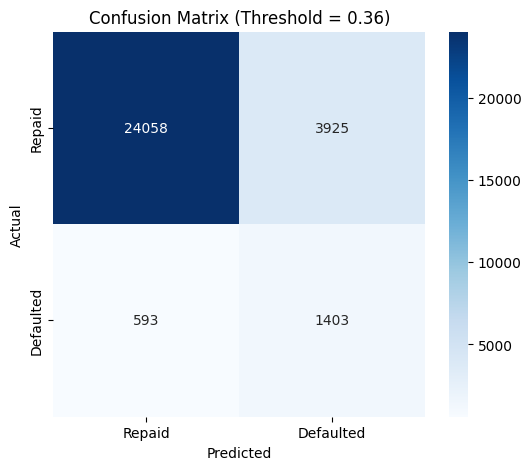

In [628]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_num, x_cat, _ in val_loader:  
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
f_beta_scores = fast_fbeta_scores(y_val, y_val_probs, thresholds, beta=2)
best_thresh_a = thresholds[np.argmax(f_beta_scores)]

y_test_probs = []
with torch.no_grad():
    for x_num, x_cat, _ in test_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh_a).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F1:", best_thresh_a)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_a:.2f})")
plt.show()

In [629]:
# Cast to float32 
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [630]:
# Model
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)

scale_pos_weight = neg_count / pos_count

model_b = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["auc"],
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.5,
    reg_alpha=0.05,
    reg_lambda=0.8,
    n_estimators=1500,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    early_stopping_rounds=100,
    callbacks=[xgb.callback.LearningRateScheduler(lambda epoch: 0.03 * (0.99 ** epoch))]
)

In [631]:
# Train
model_b.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-auc:0.84789
[1]	validation_0-auc:0.85947
[2]	validation_0-auc:0.86026
[3]	validation_0-auc:0.86143
[4]	validation_0-auc:0.86177
[5]	validation_0-auc:0.86220
[6]	validation_0-auc:0.86243
[7]	validation_0-auc:0.86249
[8]	validation_0-auc:0.86270
[9]	validation_0-auc:0.86257
[10]	validation_0-auc:0.86279
[11]	validation_0-auc:0.86296
[12]	validation_0-auc:0.86314
[13]	validation_0-auc:0.86303
[14]	validation_0-auc:0.86285
[15]	validation_0-auc:0.86314
[16]	validation_0-auc:0.86318
[17]	validation_0-auc:0.86317
[18]	validation_0-auc:0.86327
[19]	validation_0-auc:0.86334
[20]	validation_0-auc:0.86336
[21]	validation_0-auc:0.86343
[22]	validation_0-auc:0.86346
[23]	validation_0-auc:0.86346
[24]	validation_0-auc:0.86339
[25]	validation_0-auc:0.86332
[26]	validation_0-auc:0.86333
[27]	validation_0-auc:0.86342
[28]	validation_0-auc:0.86351
[29]	validation_0-auc:0.86357
[30]	validation_0-auc:0.86352
[31]	validation_0-auc:0.86353
[32]	validation_0-auc:0.86357
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,[<xgboost.call...x7a93725f38d0>]
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,['auc']


Best threshold for F1: 0.57920665
              precision    recall  f1-score   support

      Repaid       0.97      0.87      0.92     27983
   Defaulted       0.28      0.69      0.39      1996

    accuracy                           0.86     29979
   macro avg       0.63      0.78      0.66     29979
weighted avg       0.93      0.86      0.89     29979

Accuracy: 86.00%
ROC AUC: 0.866
TP=1368, FP=3568, TN=24415, FN=628
Accuracy for class 'Repaid': 87.25%
Accuracy for class 'Defaulted': 68.54%


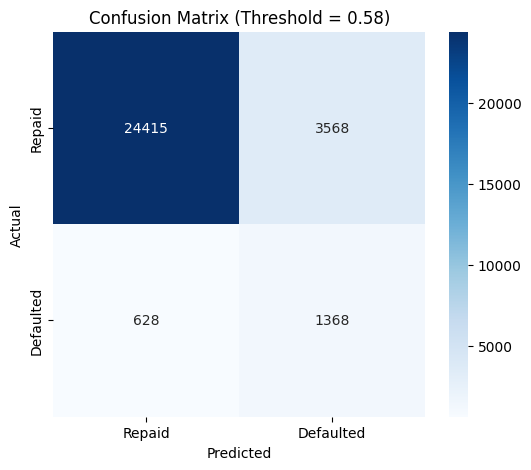

In [632]:
# Evaluation
y_probs = model_b.predict_proba(X_test)[:, 1]

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f_beta_scores = fast_fbeta_scores(y_test, y_probs, thresholds, beta=2)
best_thresh_b = thresholds[np.argmax(f_beta_scores)]

y_pred = (y_probs > best_thresh_b).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh_b)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_b:.2f})")
plt.show()

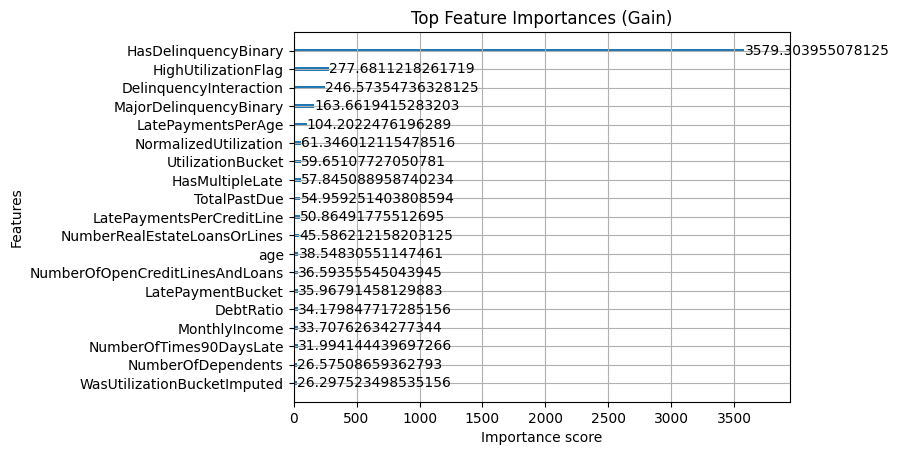

In [633]:
# Importance
xgb.plot_importance(model_b, importance_type='gain', max_num_features=X_train.shape[1])
plt.title("Top Feature Importances (Gain)")
plt.show()

In [634]:
# Save NN model
torch.save(model.state_dict(), "cr_weights.pth")

In [635]:
# Save xgb model
model_b.save_model("cr_b.json")

In [636]:
# Save for hosting
cat_maps = {}
for col in cat_col_order:
    unique_vals = X_train[col].dropna().astype(str).unique()
    cat_maps[col] = {val: idx for idx, val in enumerate(sorted(unique_vals))}

print(best_thresh_a)
print(best_thresh_b)
print(num_imputer)
print(cat_imputer)
print(robust_scaler)
print(std_scaler)
print(cat_maps)
print(cat_col_order)
print(skewed_col_order)
print(rare_maps)

joblib.dump(best_thresh_a, "threshold_a.pkl")
joblib.dump(best_thresh_b, "threshold_b.pkl")
joblib.dump(num_imputer, "num_imputer.pkl")
joblib.dump(cat_imputer, "cat_imputer.pkl")
joblib.dump(robust_scaler, "robust_scaler.pkl")
joblib.dump(std_scaler, "std_scaler.pkl")
joblib.dump(num_col_order, "num_col_order.pkl")
joblib.dump(cat_maps, "cat_maps.pkl")
joblib.dump(cat_col_order, "cat_col_order.pkl")
joblib.dump(skewed_col_order, "skewed_col_order.pkl")
joblib.dump(rare_maps, "rare_maps.pkl")

0.35746622
0.57920665
SimpleImputer(strategy='median')
SimpleImputer(strategy='most_frequent')
RobustScaler()
StandardScaler()
{'UtilizationBucket': {'0.0': 0, '1.0': 1, '2.0': 2, '3.0': 3, '4.0': 4, '5.0': 5}, 'LatePaymentBucket': {'0.0': 0, '1.0': 1, '2.0': 2}}
['UtilizationBucket', 'LatePaymentBucket']
['DelinquencyInteraction', 'DebtRatio', 'MonthlyIncome', 'NormalizedUtilization', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'TotalPastDue', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'HasMultipleLate', 'MajorDelinquencyBinary', 'NumberOfDependents', 'HasDelinquencyBinary', 'NumberOfOpenCreditLinesAndLoans', 'HighUtilizationFlag']
{'UtilizationBucket': {'Extreme'}, 'LatePaymentBucket': {'ModerateLate', 'ChronicLate', 'FrequentLate'}}


['rare_maps.pkl']